In [31]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.snowball import *
import string
import re
#from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

/home/thenhz/anaconda3/envs/nlp36/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
from nltk.corpus import stopwords

tw_data = pd.read_csv('data/hate-speech/haspeede_TW-train.tsv', sep='\t', names=['text','sentiment'])
fb_data = pd.read_csv('data/hate-speech/haspeede_FB-train.tsv', sep='\t', names=['text','sentiment'])
ami_data = pd.read_csv('data/hate-speech/it_training.tsv', sep='\t', header=0)
ami_data = ami_data[['text','misogynous']].copy()
ami_data.columns = ['text','sentiment']
data = pd.concat([tw_data])
print("data file loaded..")

data file loaded..


In [4]:
stopwords=stopwords.words('italian')

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = ItalianStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""
    tweet = " ".join(re.split("[^a-zA-Z]*", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [80]:
tokenize("Ciao a tutti dovrei andare a casa")

['cia', 'a', 'tutt', 'dovre', 'andar', 'a', 'cas']

In [5]:
tweets=data.text

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

In [7]:
import nltk.data
tagger = nltk.data.load("taggers/pos-perceptron_aubt.pickle")

#Get POS tags for tweets and save as a string
tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = tagger.tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)


In [8]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [9]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names())}

In [10]:
import xmltodict

with open('data/sentiment/it-sentiment_lexicon.lmf.xml') as fd:
    doc = xmltodict.parse(fd.read())


In [11]:
doc['LexicalResource']['Lexicon']['LexicalEntry'][0]['Sense']['Confidence']

OrderedDict([('@score', '0.333333333333'), ('@method', 'automatic')])

In [12]:
sentiment = {}
for entry in doc['LexicalResource']['Lexicon']['LexicalEntry']: 
    if entry['Sense']['Confidence']['@method']=='automatic':
        name = entry['Lemma']['@writtenForm']
        sentiment[name] = {}
        if entry['Sense']['Sentiment']['@polarity']=='positive':
            sentiment[name]['pos']= entry['Sense']['Confidence']['@score']
            sentiment[name]['neg']= 0
            sentiment[name]['neu']= 0
        if entry['Sense']['Sentiment']['@polarity']=='negative':
            sentiment[name]['neg']= entry['Sense']['Confidence']['@score']
            sentiment[name]['pos']= 0
            sentiment[name]['neu']= 0
        if entry['Sense']['Sentiment']['@polarity']=='neutral':
            sentiment[name]['neu']= entry['Sense']['Confidence']['@score']
            sentiment[name]['neg']= 0
            sentiment[name]['pos']= 0

In [13]:
#Now get other features

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def polarity_scores(tweet):
    pol_dict = {}
    pol_dict['pos'] = 0
    pol_dict['neg'] = 0
    pol_dict['neu'] = 0
    for word in tweet.split():
        if word in sentiment.values():
            pol_dict['pos'] += sentiment[word]['pos']
            pol_dict['neg'] += sentiment[word]['neg']
            pol_dict['neu'] += sentiment[word]['neu']
    return pol_dict

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    #sentiment = sentiment_analyzer.polarity_scores(tweet)
    sentiment_score = polarity_scores(tweet)
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words, lang='it_IT')
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    #print(sentiment_score)
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment_score['neg'], sentiment_score['pos'], sentiment_score['neu'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [14]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [65]:
len(other_features_names)

16

In [15]:
feats = get_feature_array(tweets)

In [16]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)
M.shape

(2998, 3642)

In [17]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

# Running model

In [18]:
X = pd.DataFrame(M)
y = data['sentiment'].astype(int)

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [53]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe = Pipeline(
        [
            ('normalizer', StandardScaler()),
            ('select', SelectFromModel(RandomForestClassifier())),
            ('model', LogisticRegression(class_weight='balanced',penalty='l2'))
        ])

param_grid = {
    'select__estimator__n_estimators' : [5, 11, 19],
    'select__estimator__min_samples_split' : [2, 3, 4, 5]
}

grid_search = GridSearchCV(pipe, 
                           param_grid,
                           cv=StratifiedKFold(n_splits=5, 
                                              random_state=42).split(X_train, y_train), 
                           verbose=4)

In [54]:
model = grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] select__estimator__min_samples_split=2, select__estimator__n_estimators=5 
[CV]  select__estimator__min_samples_split=2, select__estimator__n_estimators=5, total=   1.7s
[CV] select__estimator__min_samples_split=2, select__estimator__n_estimators=5 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.8s remaining:    0.0s


[CV]  select__estimator__min_samples_split=2, select__estimator__n_estimators=5, total=   1.6s
[CV] select__estimator__min_samples_split=2, select__estimator__n_estimators=5 
[CV]  select__estimator__min_samples_split=2, select__estimator__n_estimators=5, total=   1.8s
[CV] select__estimator__min_samples_split=2, select__estimator__n_estimators=5 
[CV]  select__estimator__min_samples_split=2, select__estimator__n_estimators=5, total=   1.6s
[CV] select__estimator__min_samples_split=2, select__estimator__n_estimators=5 
[CV]  select__estimator__min_samples_split=2, select__estimator__n_estimators=5, total=   1.5s
[CV] select__estimator__min_samples_split=2, select__estimator__n_estimators=11 
[CV]  select__estimator__min_samples_split=2, select__estimator__n_estimators=11, total=   2.1s
[CV] select__estimator__min_samples_split=2, select__estimator__n_estimators=11 
[CV]  select__estimator__min_samples_split=2, select__estimator__n_estimators=11, total=   1.7s
[CV] select__estimator__mi

[CV]  select__estimator__min_samples_split=5, select__estimator__n_estimators=5, total=   1.4s
[CV] select__estimator__min_samples_split=5, select__estimator__n_estimators=5 
[CV]  select__estimator__min_samples_split=5, select__estimator__n_estimators=5, total=   1.4s
[CV] select__estimator__min_samples_split=5, select__estimator__n_estimators=11 
[CV]  select__estimator__min_samples_split=5, select__estimator__n_estimators=11, total=   1.6s
[CV] select__estimator__min_samples_split=5, select__estimator__n_estimators=11 
[CV]  select__estimator__min_samples_split=5, select__estimator__n_estimators=11, total=   1.7s
[CV] select__estimator__min_samples_split=5, select__estimator__n_estimators=11 
[CV]  select__estimator__min_samples_split=5, select__estimator__n_estimators=11, total=   1.9s
[CV] select__estimator__min_samples_split=5, select__estimator__n_estimators=11 
[CV]  select__estimator__min_samples_split=5, select__estimator__n_estimators=11, total=   1.8s
[CV] select__estimator

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  2.0min finished


# Look which features have been selected

In [82]:
fs = grid_search.best_estimator_.named_steps['select']

feature_names_example = vectorizer.get_feature_names() + pos_vectorizer.get_feature_names() + other_features_names

selected_features = fs.transform([feature_names_example])

print(len(selected_features[0]))
selected_features

914


array([['abbiam', 'adess', 'afric', 'african', 'aiut', 'alberg', 'alfan',
        'altri', 'ammazz', 'ancor', 'anni', 'anno', 'anti migrant',
        'applic', 'arrest', 'arriv', 'assassin', 'aut', 'barcon', 'bast',
        'bast immigr', 'bastard', 'batt', 'beh', 'bergogl', 'bisogn',
        'buonism', 'cacc', 'calc', 'camb', 'camp', 'camp rom', 'cas',
        'cas lor', 'cattol', 'cazz', 'ce', 'centinai', 'centr social',
        'cerc', 'chied pizz', 'chiud', 'cib', 'circond', 'civilt',
        'clandestin', 'cmq', 'coglion', 'com', 'contr', 'cos',
        'criminal', 'cris', 'cristian', 'cultur', 'd', 'dann', 'dar',
        'democraz', 'dic', 'dichiar', 'diec', 'difend', 'dir', 'diritt',
        'discrimin', 'document', 'dop', 'due rom', 'ebre', 'ecco',
        'emergt', 'entrar', 'eserc', 'esser', 'eur', 'europ', 'europe',
        'facc', 'fam', 'famigl', 'fann', 'far', 'fatt', 'fecc', 'figl',
        'fil', 'finc', 'foll', 'forz', 'fra', 'frances', 'front', 'fuor',
        'futur'

In [55]:
y_preds = model.predict(X_test)

In [56]:
report = classification_report( y_test, y_preds )
print(report)

             precision    recall  f1-score   support

          0       0.84      0.81      0.83       201
          1       0.64      0.69      0.66        99

avg / total       0.77      0.77      0.77       300



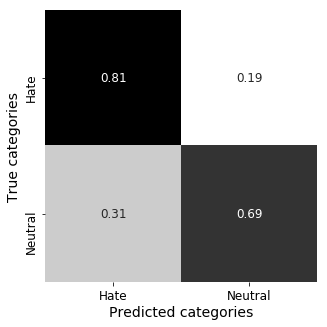

In [57]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test,y_preds)
matrix_proportions = np.zeros((2,2))
for i in range(0,2):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Neutral']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

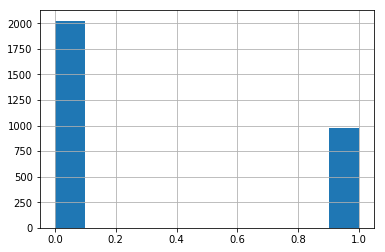

In [25]:
y.hist()

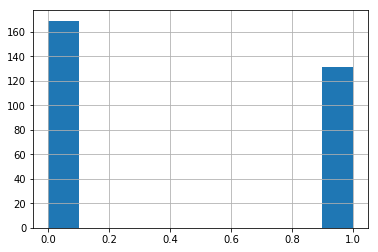

In [26]:
pd.Series(y_preds).hist()

In [27]:
#get wrong prediction

for text, prediction, label in zip(X_test, y_preds, y_test):
    if prediction != label:
        print(text, '*** has been classified as ', prediction, 'and should be ', label) 


3 *** has been classified as  0 and should be  1
6 *** has been classified as  0 and should be  1
7 *** has been classified as  1 and should be  0
8 *** has been classified as  1 and should be  0
9 *** has been classified as  1 and should be  0
15 *** has been classified as  1 and should be  0
18 *** has been classified as  1 and should be  0
19 *** has been classified as  0 and should be  1
21 *** has been classified as  1 and should be  0
23 *** has been classified as  0 and should be  1
24 *** has been classified as  1 and should be  0
39 *** has been classified as  0 and should be  1
40 *** has been classified as  0 and should be  1
50 *** has been classified as  1 and should be  0
51 *** has been classified as  1 and should be  0
55 *** has been classified as  1 and should be  0
58 *** has been classified as  0 and should be  1
60 *** has been classified as  1 and should be  0
63 *** has been classified as  1 and should be  0
70 *** has been classified as  0 and should be  1
72 **